# Getting started with Lance for computer vision

Lance is a columnar data format that is an alternative to Parquet for computer vision data. Lance makes working with visual datasets much easier and faster than before. In this tutorial, we'll go through a simple workflow showing you how to explore using pytorch/arrow backed by Lance datasets.

Lance is free and open-source:

Github: https://github.com/eto-ai/lance <br>
Docs: https://lance.readthedocs.io/en/latest/ <br>
This notebook: https://github.com/eto-ai/lance/tree/main/python/notebooks/quickstart.ipynb

## Pre-requisites

With python 3.10 installed on Mac or Linux (windows support forthcoming), let's setup a virtual environment (avoid Conda for now due to libc conflict):

```bash
python -m venv ~/.venv/lance
source ~/.venv/lance/bin/activate
pip install pylance duckdb pandas pillow matplotlib
```

In [1]:
import lance
lance.__version__

'0.0.6.dev0'

In [2]:
import duckdb
import numpy as np
import pandas as pd
import pyarrow as pa
from lance.types import Image
db = duckdb.connect()

## Working with Lance datasets

With Lance's python wrapper, we can easily read/write Arrow tables in Lance format. Let's take a look at a copy of the Oxford Pet dataset that we've already converted to Lance format.

In [3]:
uri = "s3://eto-public/datasets/oxford_pet/oxford_pet.lance"
ds = lance.dataset(uri)
assert isinstance(ds, pa.dataset.Dataset)
ds.schema.names

['filename',
 'class',
 'species',
 'breed',
 'split',
 'folder',
 'source',
 'size',
 'segmented',
 'object',
 'image']

## Explore your vision datasets with sub-second performance

It's easy to explore vision data via Lance's Arrow integration. For example, we can use duckdb to compute things like label distribution

In [4]:
%%time
df = db.query(("SELECT class, count(1) "
               "FROM ds "
               "WHERE split='val'"
               "GROUP BY 1")).to_df()
df.head()

CPU times: user 15.9 ms, sys: 7.93 ms, total: 23.9 ms
Wall time: 836 ms


,class,count(1)
0,Abyssinian,50
1,american_bulldog,50
2,american_pit_bull_terrier,50
3,basset_hound,50
4,beagle,50


Not bad! We get sub-second performance here on remote data stored on S3. <br>
Doing this on the raw dataset (txt index + xml annotations) is roughly 50-100x slower.

## Slice-and-dice-and-visualize 

I love smiling sammies, so let's see some Samoyeds

In [5]:
%%time

df = db.query("SELECT image "
              "FROM ds "
              "WHERE class='samoyed' "
              "LIMIT 10").to_df()
Image.create(df.image[0])

CPU times: user 126 ms, sys: 35.7 ms, total: 161 ms
Wall time: 5.16 s


Image(<embedded>)

duckdb and default arrow doesn't push down the limit parameter but Lance is able to.
Using Lance directly it's even faster here

In [6]:
%%time
import pyarrow.compute as pc
table = ds.scanner(columns=["image"],
                   filter=pc.field("class") == "samoyed",
                   limit=10).to_table()
table["image"].to_pylist()[0]

CPU times: user 177 ms, sys: 42.4 ms, total: 219 ms
Wall time: 3.42 s


Image(<embedded>)

## Did we mention Lance is fast?

Doing similar analytics queries on Lance is 50-10x faster than on the raw dataset (not to mention very little code by comparison)

![image.png](https://github.com/eto-ai/lance/raw/main/docs/lance_perf.png)
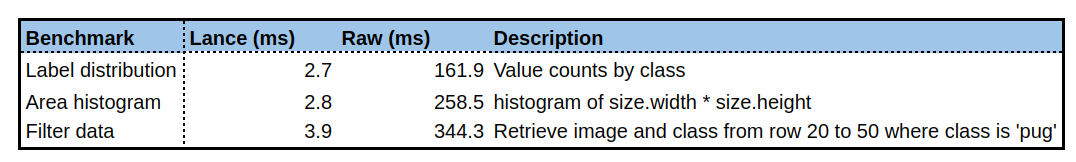

With parquet you tradeoff scan vs random access performance by tuning the row_group_size. With Lance, you can have your cake and eat it too. Take a look at the performance of Lance vs Parquet below ([benchmark code](https://github.com/eto-ai/lance/blob/main/python/benchmarks/coco/analytics.py))

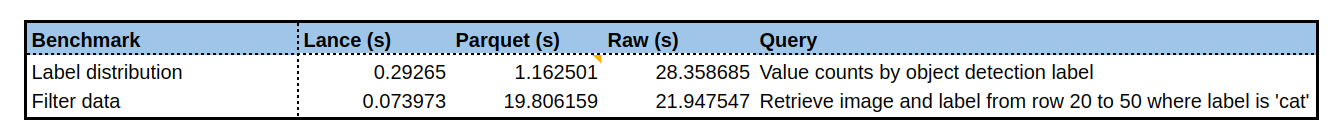

## Inference

Lance comes with a Pytorch dataset so it's super easy to extract insights from vision data

In [7]:
import itertools
import multiprocessing as mp
import pyarrow.compute as pc
import torch
from torch.utils.data import DataLoader
import torchvision.models.detection as detection
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.utils import draw_bounding_boxes
from lance.pytorch.data import LanceDataset

if torch.cuda.is_available():
    device = torch.device("cuda")
    n_pred = 128
else:
    device = torch.device("cpu")
    n_pred = 12
    
print(device)

cuda


Used pre-trained object detection model

In [8]:
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1
model = detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights, box_score_thresh=0.9)
model.eval()
model.to(device)

type(model)

torchvision.models.detection.faster_rcnn.FasterRCNN

Create a data loader from Lance

In [9]:
uri = "s3://eto-public/datasets/coco/coco.lance"
ds = LanceDataset(uri, columns=["image"],
                  filter=pc.field("split") == "test",
                  transform=weights.transforms(), batch_size=64)

pred_loader = DataLoader(ds, num_workers=0)

Run the inference

In [10]:
%%time

def extract_pred(img, pred):
    label_ids = pred["labels"].cpu().numpy().astype(int)
    labels = [weights.meta["categories"][i] for i in label_ids]
    boxes = pred["boxes"].cpu().numpy().astype('double')
    return to_pil_image(img), labels, boxes

data = []
with torch.no_grad():
    for img in itertools.islice(pred_loader, n_pred):
        pred = model([img.to(device)])[0]
        data.append(extract_pred(img, pred))

CPU times: user 18.6 s, sys: 956 ms, total: 19.5 s
Wall time: 38.7 s


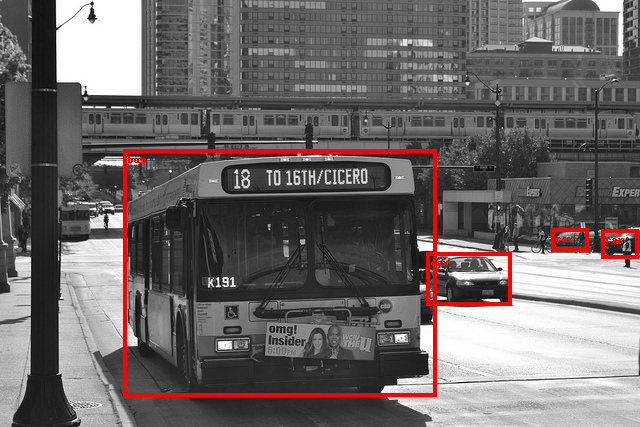

In [11]:
to_pil_image(draw_bounding_boxes(pil_to_tensor(data[0][0]),
                                 boxes=torch.from_numpy(data[0][2]),
                                 labels=data[0][1],
                                 colors="red",
                                 width=4))

### Insights

Using the predicted labels, it's easy to get a distribution of what's in these images

In [12]:
(pd.Series([d[1] for d in data])
 .explode()
 .value_counts()
 .head(10))

person           108
bird              15
sheep              8
airplane           8
tennis racket      8
elephant           7
kite               7
banana             6
car                6
donut              6
dtype: int64

## Conclusion

In under one minute we were able to explore two different CV datasets stored on S3. Lance makes it really easy to explore large collections of images.

## Roadmap

The Lance roadmap is chock-full of exciting features:

1. Data versioning and schema evolution (update annotations, snapshot new model results, etc)
2. CV/ML indexing support (vector indices, inverted index)
3. Rich media type support (images, videos, 3d point clouds, pdfs, audio, and more)

## We value your feedback

If you have questions, feature requests, or bug reports, please don't hesitate to:

1. File a github issue: https://github.com/eto-ai/lance/issues
OR
2. Send us an email contact@eto.ai

We'd love to hear from you